In [34]:
from keras.models import Sequential
from keras.layers import Convolution2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import PIL

import os

import numpy as np

import matplotlib.pyplot as plt

In [35]:
# Parameters
img_width = 101
img_height = 101
batch_size = 32

In [36]:
import tensorflow as tf

keras = tf.keras

IMG_SHAPE = (img_height, img_width, 3)

In [37]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = X_train
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = X_val
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [38]:
# Get image data
train_data_dir = './data/training'
test_data_dir = './data/testing'
train_datagen = ImageDataGenerator(rescale = 1./255, vertical_flip = True, horizontal_flip=True,rotation_range=20,
                                   shear_range=5.0, channel_shift_range=50.0,
                                   validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Run this
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

labels_pd = pd.read_csv(dir_train_labels)
labels_0_sampled = labels_pd[labels_pd["label"] == 0].sample(n = 505)
labels_sampled = labels_0_sampled.append(labels_pd[labels_pd["label"] == 1])
ids       = labels_sampled.id.values
data      = []
for identifier in ids:
    fname     = dir_train_images + identifier.astype(str) + '.tif'
    image     = mpl.image.imread(fname)
    data.append(image)
data = np.array(data) # Convert to Numpy array


X = data/1500
y = labels_sampled.label.values

KeyboardInterrupt: 

In [39]:
# Generate image label dataframe
# Dont run this
traindf = pd.read_csv("./data/labels_training.csv",dtype=str)
def append_ext(fn):
    return fn+".tif"
traindf["id"]=traindf["id"].apply(append_ext)
traindf = traindf.sample(frac=1)

train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    batch_size = batch_size,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='validation',
    batch_size = 225)

Found 1275 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.


## Try extracting features to do SVM ##

In [46]:
training_features = []
for i in range(1500):
    training_features.append(np.array(base_model(train_generator.next())).ravel())

In [47]:
np.savetxt("training_features_InceptionV3.csv", training_features, delimiter=",")

In [55]:
from sklearn import svm
from sklearn.metrics import classification_report
labels = train_generator.classes
clf = svm.SVC(kernel='rbf', degree = 3, probability=True, C=0.1, gamma='scale')
clf.fit(training_features, labels)

# Primary evaluation
score = clf.predict_proba(training_features)
auc = metrics.roc_auc_score(labels, score[:,1])
print(auc)
print (classification_report(labels, score[:,1]>0.5))

0.970727896910294
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       995
           1       0.91      0.81      0.86       505

    accuracy                           0.91      1500
   macro avg       0.91      0.89      0.90      1500
weighted avg       0.91      0.91      0.91      1500



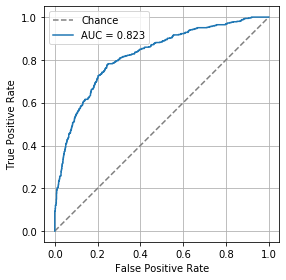

In [99]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(np.array(training_features),np.array(labels),5,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [93]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42,
    batch_size=1
)
testing_features = []
for i in range(558):
    testing_features.append(np.array(base_model(test_generator.next())).ravel())


Found 558 images belonging to 1 classes.


In [100]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
clf.fit(training_features, labels)

score = clf.predict_proba(testing_features)
dir_test_ids      = './data/sample_submission.csv'
dir_test_images   = './data/testing/'
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                                   'score':  score[:,1]})
submission_file.to_csv('Inception_SVM2.csv',
                           columns=['id','score'],
                           index=False)

In [102]:
peer = pd.read_csv('submission_PCA_SVM_3C.csv')
peer = pd.read_csv('Inception_SVM.csv')
np.corrcoef(score[:,1],np.array(peer.score))

array([[1.        , 0.90536866],
       [0.90536866, 1.        ]])

## Transfer learning ##

In [40]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger

In [49]:
def CNN_mod(lr, weight, name, epoch = 30):
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    filename = 'D:\\MIDS\\RedTeam\\' +name+ '.csv'
    csv_logger = CSVLogger(filename, append=True, separator=';')
    
    model.fit_generator(train_generator, validation_data=validation_generator ,
                        epochs=epoch, class_weight=weight, callbacks=[csv_logger])
    
    score = model.predict(train_generator)
    labels = train_generator.classes
    auc = metrics.roc_auc_score(labels, score.ravel())
    return (score, labels, auc)

In [50]:
lr = [0.0001, 0.0005, 0.001, 0.01, 0.1]
weight = [{0:1., 1:1.}, {0:1., 1:1.5}, {0:1., 1:2.}, {0:1., 1:2.5}]
# column in weight, row is lr
score_all = []
labels_all = []
auc_all = []
for rate in lr:
    s_row = []
    l_row = []
    a_row = []
    for w in weight:
        s, l, a = CNN_mod(rate, w, name = 'run_lr'+str(int(rate*10000)) +'_w' + str(int(w[1]*10)), epoch = 30)
        s_row.append(s)
        l_row.append(l)
        a_row.append(a)
    score_all.append(s_row)
    labels_all.append(l_row)
    auc_all.append(a_row)

Epoch 1/30
40/40 [==============================] - 21s 524ms/step - loss: 0.7103 - accuracy: 0.5388 - val_loss: 0.7583 - val_accuracy: 0.4756
Epoch 2/30
40/40 [==============================] - 21s 533ms/step - loss: 0.6732 - accuracy: 0.6314 - val_loss: 0.7028 - val_accuracy: 0.5911
Epoch 3/30
40/40 [==============================] - 22s 543ms/step - loss: 0.6673 - accuracy: 0.6267 - val_loss: 0.7062 - val_accuracy: 0.6044
Epoch 4/30
40/40 [==============================] - 22s 548ms/step - loss: 0.6643 - accuracy: 0.6353 - val_loss: 0.6653 - val_accuracy: 0.6356
Epoch 5/30
40/40 [==============================] - 22s 550ms/step - loss: 0.6603 - accuracy: 0.6494 - val_loss: 0.6536 - val_accuracy: 0.6622
Epoch 6/30
40/40 [==============================] - 22s 550ms/step - loss: 0.6510 - accuracy: 0.6557 - val_loss: 0.6445 - val_accuracy: 0.6400
Epoch 7/30
40/40 [==============================] - 22s 552ms/step - loss: 0.6506 - accuracy: 0.6439 - val_loss: 0.7025 - val_accuracy: 0.6356

KeyboardInterrupt: 

In [55]:
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False),
#              loss=keras.losses.sparse_categorical_crossentropy,
#              metrics=['accuracy'])

In [56]:
#callbackobj = tf.compat.v1.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
#          write_graph=True, write_images=True, write_grads = True, update_freq = 1)

In [13]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [16]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# Train the output layer for a few epoches
model.fit_generator(train_generator, validation_data=validation_generator ,epochs=20, class_weight=class_w)

Epoch 1/20
20/20 [==============================] - 20s 1s/step - loss: 0.8361 - accuracy: 0.6635 - val_loss: 0.9618 - val_accuracy: 0.5689
Epoch 2/20
20/20 [==============================] - 20s 1s/step - loss: 0.8466 - accuracy: 0.6431 - val_loss: 0.2992 - val_accuracy: 0.6178
Epoch 3/20
20/20 [==============================] - 20s 1s/step - loss: 0.8330 - accuracy: 0.6604 - val_loss: 0.1439 - val_accuracy: 0.5867
Epoch 4/20
20/20 [==============================] - 20s 1s/step - loss: 0.8440 - accuracy: 0.6596 - val_loss: 0.9651 - val_accuracy: 0.6356
Epoch 5/20
20/20 [==============================] - 21s 1s/step - loss: 0.8405 - accuracy: 0.6533 - val_loss: 0.3571 - val_accuracy: 0.6400
Epoch 6/20
20/20 [==============================] - 20s 1s/step - loss: 0.8084 - accuracy: 0.6855 - val_loss: 0.5333 - val_accuracy: 0.6756
Epoch 7/20
20/20 [==============================] - 20s 1s/step - loss: 0.8266 - accuracy: 0.6808 - val_loss: 0.8698 - val_accuracy: 0.6044
Epoch 8/20
20/20 [==

KeyboardInterrupt: 

In [18]:
#score = model.predict_generator(validation_generator)
#labels = validation_generator.classes
from sklearn.metrics import classification_report

score = model.predict(train_generator)
labels = train_generator.classes
#plot_roc(labels, score.ravel())
auc = metrics.roc_auc_score(labels, score.ravel())
print(auc)
print (classification_report(labels, score.ravel()>=0.5))

0.4861173108328797
              precision    recall  f1-score   support

           0       0.62      0.23      0.34       835
           1       0.33      0.73      0.46       440

    accuracy                           0.41      1275
   macro avg       0.48      0.48      0.40      1275
weighted avg       0.52      0.41      0.38      1275



In [19]:
(model.get_weights())[-2]

array([[ 0.03731085],
       [ 0.10650838],
       [-0.13288498],
       ...,
       [ 0.05345095],
       [-0.14360557],
       [ 0.04681378]], dtype=float32)

In [31]:
plt.hist(score.ravel())

1275

In [28]:
# See augmented image
train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    batch_size = batch_size,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='binary',
    save_to_dir = "D:\\MIDS\\RedTeam\\augmeted_solar")

Found 1500 validated image filenames belonging to 2 classes.


In [29]:
train_generator.next()

(array([[[[0.5902355 , 0.5372161 , 0.5109079 ],
          [0.5998315 , 0.5384156 , 0.5145064 ],
          [0.579139  , 0.53052855, 0.5059895 ],
          ...,
          [0.7248187 , 0.68168145, 0.60717165],
          [0.72512925, 0.67514575, 0.6109053 ],
          [0.719872  , 0.6625721 , 0.60549724]],
 
         [[0.5712325 , 0.5359384 , 0.5020569 ],
          [0.57003295, 0.53473884, 0.50325644],
          [0.57913446, 0.5358285 , 0.50674504],
          ...,
          [0.72583854, 0.6827013 , 0.6081915 ],
          [0.7241094 , 0.67004657, 0.6119251 ],
          [0.7178323 , 0.66155225, 0.60039806]],
 
         [[0.568302  , 0.5352469 , 0.4993898 ],
          [0.5738196 , 0.53852546, 0.49946976],
          [0.57262015, 0.53732604, 0.5006693 ],
          ...,
          [0.7268232 , 0.68361545, 0.6092113 ],
          [0.7230896 , 0.6649474 , 0.61294496],
          [0.71579266, 0.66053236, 0.5952988 ]],
 
         ...,
 
         [[0.15690783, 0.25364155, 0.26539102],
          [0.16306